In [ ]:
import numpy as np
from tqdm import tqdm

# TODO: var_rot_speed in rad/s^2, var_speed in mm/s^2, var_camera 
# TODO: get data from thymio and camera
# TODO: average speed and rotational speed
# TODO: if data is bad, might need to consider variance of left and right motor separately
# TODO: question for TA: ok if motor variance split equally in state and measurement variance and camera variance all only measurement variance?

var_motors = [75.72, 0.002692]  # variance for the motors [translational, rotational] from calibrations_thymio.ipynb
var_camera = [2.25, 2.25, 0.005]  # variance for the camera [x, y, theta] from calibrations_camera.ipynb

# Extended Kalman Filter
state contains position (x, y, rotation) and velocity (translational, rotational) with units [mm, mm, rad, mm/s, rad/s]
$ x = \begin{bmatrix} x & y & \theta & v & \omega \end{bmatrix} ^T$

control $u = (v_{cmd}, \omega_{cmd})$ from left/right wheel speeds with:
$$
v_{cmd} = (v_r + v_l)/2 \\
\omega_{cmd} = (v_r - v_l)/L \\
v_{l,r} = speed_{l,r} \cdot speed-to-mms
$$

measurements:
    Camera pose: z_cam = [x_cam, y_cam, θ_cam]^T
    Velocity measurement: z_mot = [v_meas, ω_meas]^T


non-linear discrete-time state-space model $ x_{k+1} = f(x_k, T_s) + w_k $:
$$
x_{k+1} = \begin{bmatrix}
            x_k + v \cdot cos(\theta_k) \cdot T_s \\
            y_k + v \cdot sin(\theta_k) \cdot T_s \\
            \theta_k + \omega \cdot T_s \\
            v_k \\
            \omega_k
            \end{bmatrix}
            + w_k
$$
with process noise (on states) w_k with zero mean and covariance Q. Here we use 
$$ 
Q = G \cdot \begin{bmatrix} 
                \sigma_{motor,trans} ^2 & 0 \\
                0 & \sigma_{motor,rot} ^2
                \end{bmatrix}
        \cdot G^T 
        + \begin{bmatrix}
                \sigma_x ^2 & 0 & 0 & 0 & 0 \\
                0 & \sigma_y ^2 & 0 & 0 & 0 \\
                0 & 0 & \sigma_\theta ^2 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0 \\
                0 & 0 & 0 & 0 & 0
        \end{bmatrix}
$$
with 
$$ G = \begin{bmatrix} 
        \frac{df}{dv} & \frac{df}{d\omega} 
        \end{bmatrix} 
    = \begin{bmatrix}
        cos(\theta_k) \cdot T_s & 0 \\
        sin(\theta_k) \cdot T_s & 0 \\
        0 & T_s \\
        1 & 0 \\
        0 & 1 
        \end{bmatrix}
$$

output model (measurements) $ y_k = H \cdot x_k + v_k $
with all states measured (first 3 from camera, last two from motor speeds), therefore:
$$ H = \begin{bmatrix}
        1 & 0 & 0 & 0 & 0 \\
        0 & 1 & 0 & 0 & 0 \\
        0 & 0 & 1 & 0 & 0 \\
        0 & 0 & 0 & 1 & 0 \\
        0 & 0 & 0 & 0 & 1
        \end{bmatrix}
$$
and measurement noise $v_k$ with zero mean and covariance R. Here we assume, that all measurement noises are independent and therefore R is a diagonal matrix:
$$ R = \begin{bmatrix}
        \sigma_x ^2 & 0 & 0 & 0 & 0 \\
        0 & \sigma_y ^2 & 0 & 0 & 0\\
        0 & 0 & \sigma_\theta ^2  & 0 & 0 \\
        0 & 0 & 0 & \sigma_{motor,trans} ^2 & 0\\
        0 & 0 & 0 & 0 & \sigma_{motor,rot} ^2
        \end{bmatrix}
$$

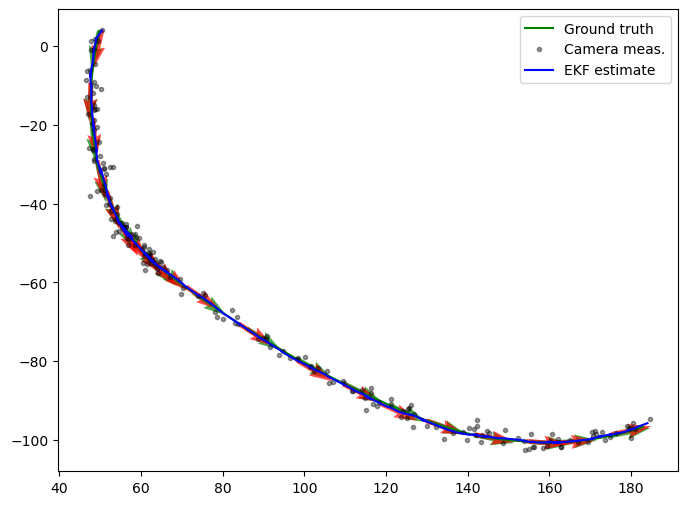

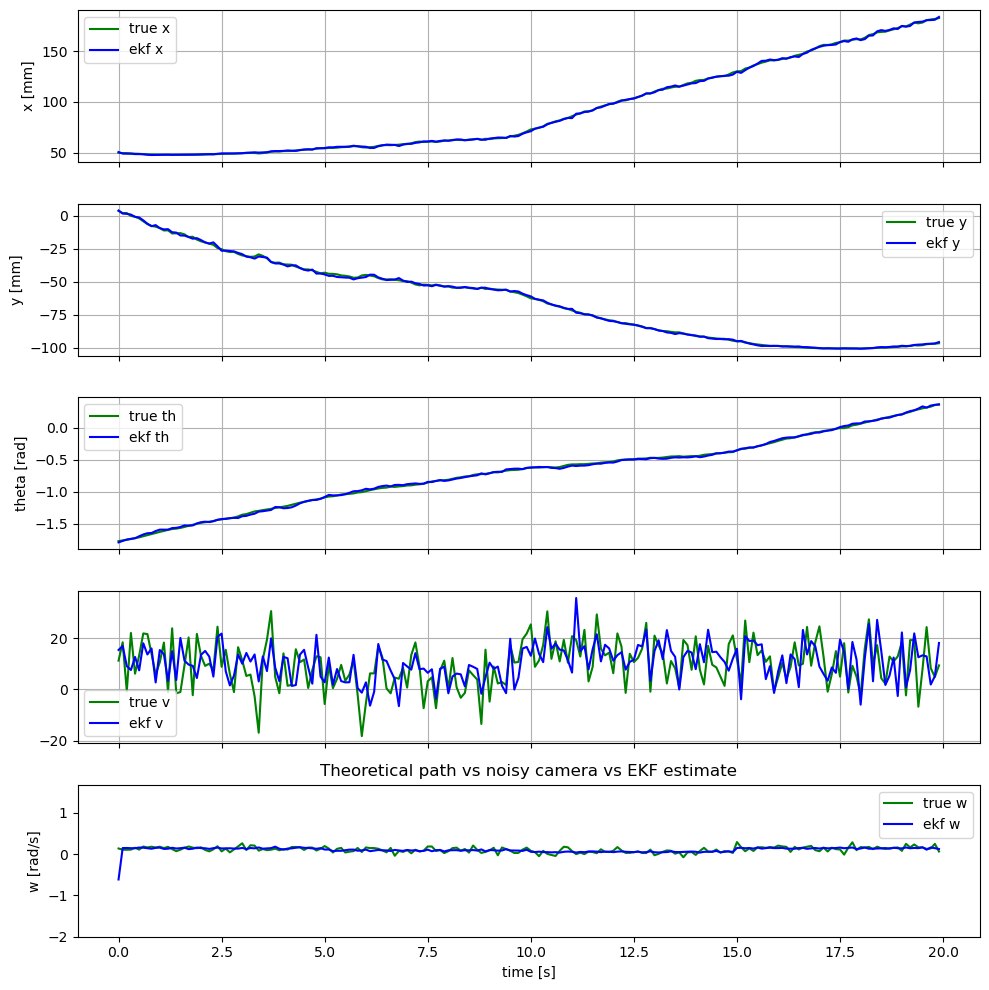

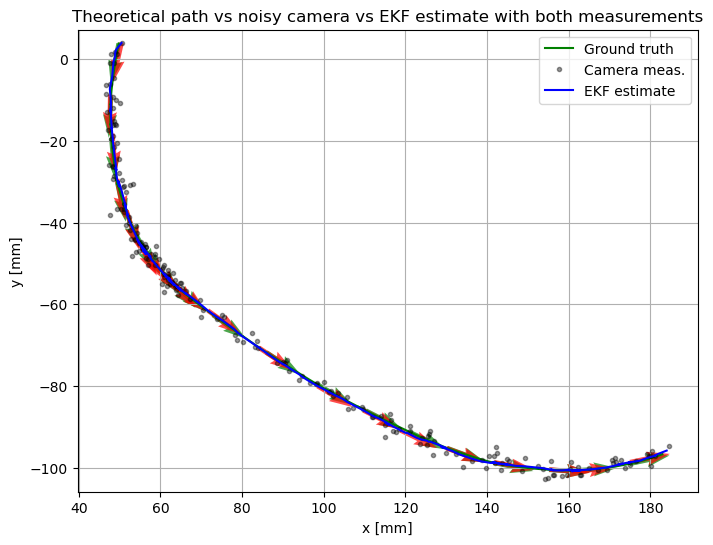

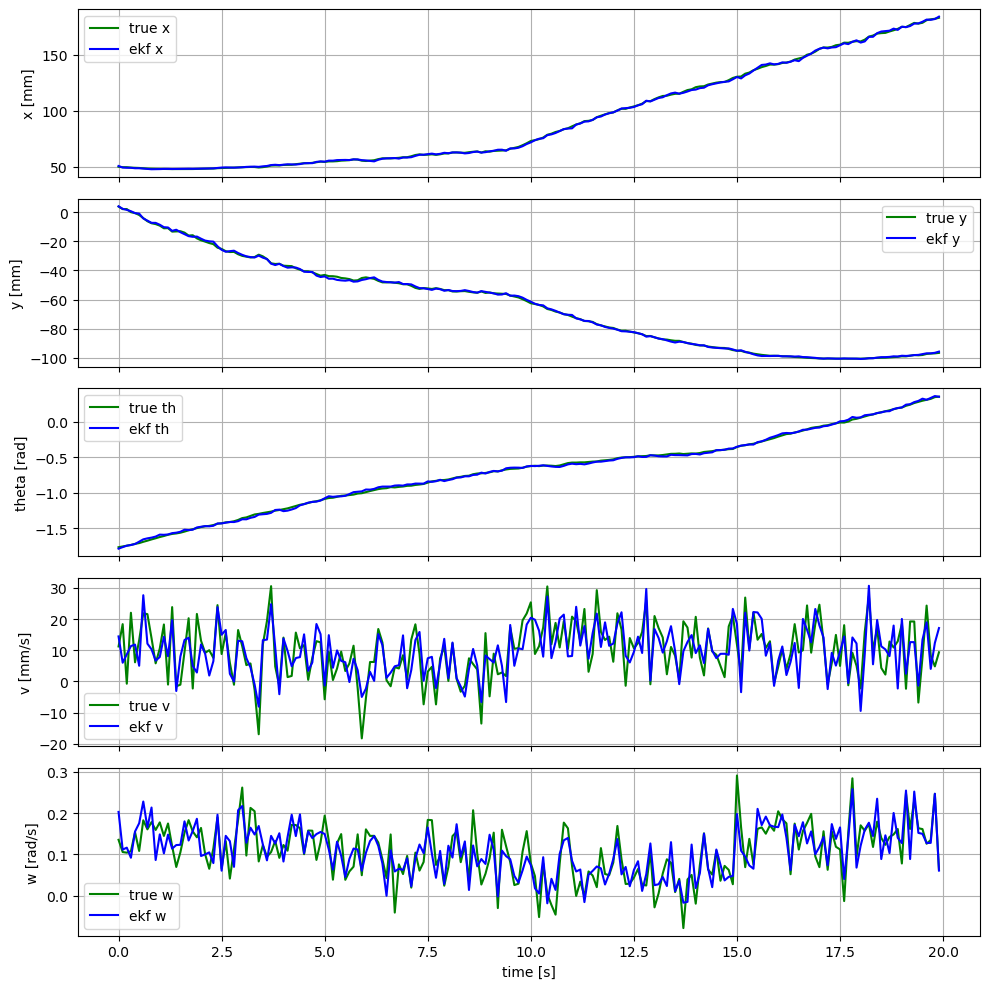

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Filtering import ekf_predict, ekf_update_cam, motors_to_vw, wrap_angle, ekf_update_both, ekf_update_motors

def simulate_and_plot():
    Ts = 0.1
    T = 20.0
    N = int(T / Ts)

    L = 95.0                 # mm
    speed_to_mms = 0.3375    # Thymio unit -> mm/s

    # Commanded wheel speeds (piecewise to make a curved path)
    vl_cmd_profile = np.ones(N) * 10.0
    vr_cmd_profile = np.ones(N) * 50.0
    # Add a turning segment
    vr_cmd_profile[N//4:N//2] = 35.0
    vl_cmd_profile[N//2:3*N//4] = 35.0

    # Process noise for EKF (tune) (from model-mismatch/random-walk/control execution)
    q_proc = (
        1e-3, 1e-2, 1e-4,   # q_x, q_y, q_theta (model mismatch)
        75.72,  0.002692,         # q_v_ctrl, q_omega_ctrl (control execution noise)
        1e-2, 1e-5          # q_v_bias, q_omega_bias (random walk on v, omega)
    )
    # Camera measurement noise (tune)
    r_cam = (1.435, 1.864, 0.001496)  # [mm^2, mm^2, rad^2]
    r_mot = (75.72, 0.002692)    # motor noise on v, omega

    # Noise for generating “actual” robot motion
    # Assume commands are noisy and there is slip
    rng = np.random.default_rng(0)
    v_exec_noise_std = np.sqrt(q_proc[3])   # mm/s
    w_exec_noise_std = np.sqrt(q_proc[4])   # rad/s

    # Camera measurement noise std (should be consistent with r_cam)
    cam_x_std, cam_y_std, cam_th_std = np.sqrt(r_cam)
    mot_v_std, mot_w_std = np.sqrt(r_mot)

    # Containers
    x_true_hist = np.zeros((N, 5))   # [x,y,theta,v,omega]
    x_cam_hist  = np.zeros((N, 3))   # noisy camera [x,y,theta]
    x_ekf_hist  = np.zeros((N, 5))
    P_diag_hist = np.zeros((N, 5))
    x_true_both_hist = np.zeros((N, 5))   # [x,y,theta,v,omega]
    x_meas_both_hist = np.zeros((N, 5))   # noisy camera + motor [x,y,theta,v,omega]
    x_ekf_both_hist  = np.zeros((N, 5))
    P_both_diag_hist = np.zeros((N, 5))

    # Initial states
    x_true = np.array([50, 5, 4.5, 0.0, 0.0], dtype=float)
    x_est  = np.zeros(5)
    P_est  = 1000.0 * np.eye(5)
    
        # ============ Run simulation ============
    for k in range(N):
        # Commands (what you send)
        vl_cmd = vl_cmd_profile[k]
        vr_cmd = vr_cmd_profile[k]
        v_cmd, w_cmd = motors_to_vw(vl_cmd, vr_cmd, speed_to_mms, L)

        # Actual executed velocities (commands + execution noise)
        v_exec = v_cmd + rng.normal(0, v_exec_noise_std)
        w_exec = w_cmd + rng.normal(0, w_exec_noise_std)

        # Ground truth propagation
        x, y, th, _, _ = x_true
        x_true = np.array([
            x + v_exec * Ts * np.cos(th),
            y + v_exec * Ts * np.sin(th),
            wrap_angle(th + w_exec * Ts),
            v_exec,
            w_exec
        ])

        # Camera measurement
        z_cam = np.array([
            x_true[0] + rng.normal(0, cam_x_std),
            x_true[1] + rng.normal(0, cam_y_std),
            wrap_angle(x_true[2] + rng.normal(0, cam_th_std))
        ])
        # motor measurement
        z_mot = np.array([
            x_true[3] + rng.normal(0, mot_v_std),
            x_true[4] + rng.normal(0, mot_w_std)
        ])
        
        # EKF: predict with wheel-speed control (do not also measure v, w)
        x_pred, P_pred = ekf_predict(x_est, P_est, (v_cmd, w_cmd), Ts, q_proc)
        # EKF: update with camera measurement
        x_upd1, P_upd1 = ekf_update_cam(x_pred, P_pred, z_cam, r_cam)
        # Log
        x_true_hist[k] = x_true
        x_cam_hist[k]  = z_cam
        x_ekf_hist[k]  = x_upd1
        P_diag_hist[k] = np.diag(P_upd1)
        
        # EKF: update with both camera and motor measurements
        z_full = np.hstack((z_cam, z_mot))
        #r_full = (r_cam[0], r_cam[1], r_cam[2], r_mot[0], r_mot[1])
        # both updates
        #x_est, P_est = ekf_update_both(x_pred, P_pred, z_full, r_full)
        
        x_est, P_est = ekf_update_motors(x_upd1, P_upd1, z_mot, r_mot)
        
        # Log
        x_true_both_hist[k] = x_true
        x_meas_both_hist[k] = z_full
        x_ekf_both_hist[k]  = x_est
        P_both_diag_hist[k] = np.diag(P_est)
        
    # ============ Plot results ============
    # Trajectory with orientations
    plt.figure(figsize=(8,6))
    plt.plot(x_true_hist[:,0], x_true_hist[:,1], 'g-', label='Ground truth')
    plt.plot(x_cam_hist[:,0], x_cam_hist[:,1], 'k.', alpha=0.4, label='Camera meas.')
    plt.plot(x_ekf_hist[:,0], x_ekf_hist[:,1], 'b-', label='EKF estimate')
    # orientations (sparse quivers)
    step = max(1, N//20)
    Larr = 10.0 #arrow length
    plt.quiver(x_true_hist[::step,0], x_true_hist[::step,1],
               Larr*np.cos(x_true_hist[::step,2]), Larr*np.sin(x_true_hist[::step,2]),
               color='g', angles='xy', scale_units='xy', scale=1, alpha=0.7)
    plt.quiver(x_ekf_hist[::step,0], x_ekf_hist[::step,1],
               Larr*np.cos(x_ekf_hist[::step,2]), Larr*np.sin(x_ekf_hist[::step,2]),
               color='r', angles='xy', scale_units='xy', scale=1, alpha=0.7)
    plt.legend()

    # Time series: pose and velocities
    t = np.arange(N)*Ts
    fig, axs = plt.subplots(5, 1, figsize=(10,10), sharex=True)
    axs[0].plot(t, x_true_hist[:,0], 'g', label='true x')
    axs[0].plot(t, x_ekf_hist[:,0], 'b', label='ekf x')
    axs[0].set_ylabel('x [mm]'); axs[0].grid(); axs[0].legend()

    axs[1].plot(t, x_true_hist[:,1], 'g', label='true y')
    axs[1].plot(t, x_ekf_hist[:,1], 'b', label='ekf y')
    axs[1].set_ylabel('y [mm]'); axs[1].grid(); axs[1].legend()

    axs[2].plot(t, x_true_hist[:,2], 'g', label='true th')
    axs[2].plot(t, x_ekf_hist[:,2], 'b', label='ekf th')
    axs[2].set_ylabel('theta [rad]'); axs[2].grid(); axs[2].legend()

    axs[3].plot(t, x_true_hist[:,3], 'g', label='true v')
    axs[3].plot(t, x_ekf_hist[:,3], 'b', label='ekf v')
    #axs[3].set_color('r', angles='xy', scale_units='xy', scale=1, alpha=0.7)
    plt.axis('equal')
    plt.grid(True)
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    plt.title('Theoretical path vs noisy camera vs EKF estimate')
    plt.ylabel('v [mm/s]'); axs[3].grid(); axs[3].legend()

    axs[4].plot(t, x_true_hist[:,4], 'g', label='true w')
    axs[4].plot(t, x_ekf_hist[:,4], 'b', label='ekf w')
    axs[4].set_ylabel('w [rad/s]'); axs[4].set_xlabel('time [s]'); axs[4].grid(); axs[4].legend()

    plt.tight_layout()
    plt.show()
    


    # Trajectory with orientations from both
    plt.figure(figsize=(8,6))
    plt.plot(x_true_both_hist[:,0], x_true_both_hist[:,1], 'g-', label='Ground truth')
    plt.plot(x_meas_both_hist[:,0], x_meas_both_hist[:,1], 'k.', alpha=0.4, label='Camera meas.')
    plt.plot(x_ekf_both_hist[:,0], x_ekf_both_hist[:,1], 'b-', label='EKF estimate')
    # orientations (sparse quivers)
    step = max(1, N//20)
    Larr = 10.0
    plt.quiver(x_true_both_hist[::step,0], x_true_both_hist[::step,1],
               Larr*np.cos(x_true_both_hist[::step,2]), Larr*np.sin(x_true_both_hist[::step,2]),
               color='g', angles='xy', scale_units='xy', scale=1, alpha=0.7)
    plt.quiver(x_ekf_both_hist[::step,0], x_ekf_both_hist[::step,1],
               Larr*np.cos(x_ekf_both_hist[::step,2]), Larr*np.sin(x_ekf_both_hist[::step,2]),
               color='r', angles='xy', scale_units='xy', scale=1, alpha=0.7)
    plt.axis('equal')
    plt.grid(True)
    plt.xlabel('x [mm]')
    plt.ylabel('y [mm]')
    plt.title('Theoretical path vs noisy camera vs EKF estimate with both measurements')
    plt.legend()

    # Time series: pose and velocities
    t = np.arange(N)*Ts
    fig, axs = plt.subplots(5, 1, figsize=(10,10), sharex=True)
    axs[0].plot(t, x_true_both_hist[:,0], 'g', label='true x')
    axs[0].plot(t, x_ekf_both_hist[:,0], 'b', label='ekf x')
    axs[0].set_ylabel('x [mm]'); axs[0].grid(); axs[0].legend()

    axs[1].plot(t, x_true_both_hist[:,1], 'g', label='true y')
    axs[1].plot(t, x_ekf_both_hist[:,1], 'b', label='ekf y')
    axs[1].set_ylabel('y [mm]'); axs[1].grid(); axs[1].legend()

    axs[2].plot(t, x_true_both_hist[:,2], 'g', label='true th')
    axs[2].plot(t, x_ekf_both_hist[:,2], 'b', label='ekf th')
    axs[2].set_ylabel('theta [rad]'); axs[2].grid(); axs[2].legend()

    axs[3].plot(t, x_true_both_hist[:,3], 'g', label='true v')
    axs[3].plot(t, x_ekf_both_hist[:,3], 'b', label='ekf v')
    axs[3].set_ylabel('v [mm/s]'); axs[3].grid(); axs[3].legend()

    axs[4].plot(t, x_true_both_hist[:,4], 'g', label='true w')
    axs[4].plot(t, x_ekf_both_hist[:,4], 'b', label='ekf w')
    axs[4].set_ylabel('w [rad/s]'); axs[4].set_xlabel('time [s]'); axs[4].grid(); axs[4].legend()

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    simulate_and_plot()
    